# シンプルなLSTMの実装
LSTM層を用いてシンプルなニューラルネットワークを構築し、時系列データを学習します。  
今回は、通常のRNNとLSTMを比較します。

## 訓練用データの作成
訓練用のデータを作成します。  
サイン関数に乱数でノイズを加えたデータを作成し、過去の時系列データから未来の値を予測できるようにします。  
以前にシンプルなRNNを構築した際と異なり、今回は最後の時刻の出力のみ利用します。

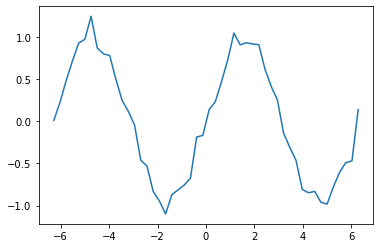

(40, 10, 1)
(40, 1)


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

x_data = np.linspace(-2*np.pi, 2*np.pi)  # -2πから2πまで
sin_data = np.sin(x_data) + 0.1*np.random.randn(len(x_data))  # sin関数に乱数でノイズを加える

plt.plot(x_data, sin_data)
plt.show()

n_rnn = 10  # 時系列の数
n_sample = len(x_data)-n_rnn  # サンプル数
x = np.zeros((n_sample, n_rnn))  # 入力
t = np.zeros((n_sample,))  # 正解、最後の時刻のみ

for i in range(0, n_sample):
    x[i] = sin_data[i:i+n_rnn]
    t[i] = sin_data[i+n_rnn]  # 入力の時系列より一つ後の値

x = x.reshape(n_sample, n_rnn, 1)  # （サンプル数、時系列の数、入力層のニューロン数）
print(x.shape)
t = t.reshape(n_sample, 1)  # （サンプル数、入力層のニューロン数）
print(t.shape)

## SimpleRNNとLSTMの比較
Kerasを使って通常のRNN、およびLSTMを構築します。  
Kerasにおいて、LSTM層はSimpleRNN層と同じ方法で追加することができます。

In [2]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

batch_size = 8  # バッチサイズ
n_in = 1  # 入力層のニューロン数
n_mid = 20  # 中間層のニューロン数
n_out = 1  # 出力層のニューロン数

# 比較のための通常のRNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(n_mid, input_shape=(n_rnn, n_in), return_sequences=False))  # 最後の出力のみ使用
model_rnn.add(Dense(n_out, activation="linear"))
model_rnn.compile(loss="mean_squared_error", optimizer="sgd")
print(model_rnn.summary())

# LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(n_mid, input_shape=(n_rnn, n_in), return_sequences=False))
model_lstm.add(Dense(n_out, activation="linear"))
model_lstm.compile(loss="mean_squared_error", optimizer="sgd")
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20)                440       
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
None


SimpleRNNよりも、LSTMの方がパラメータがずっと多いですね。

## 学習
構築したRNNのモデルを使って、学習を行います。  

In [3]:
import time

epochs = 200

# 通常のRNN
start_time = time.time()
history_rnn = model_rnn.fit(x, t, epochs=epochs, batch_size=batch_size, verbose=0)
print("学習時間 --通常のRNN--:", time.time() - start_time)

# LSTM
start_time = time.time()
history_lstm = model_lstm.fit(x, t, epochs=epochs, batch_size=batch_size, verbose=0)
print("学習時間 --LSTM--:", time.time() - start_time)

学習時間 --通常のRNN--: 1.272536277770996
学習時間 --LSTM--: 2.3277230262756348


エポック数が同じ場合、パラメータ数が多いためLSTMの方が学習にずっと時間がかかります。

## 学習の推移
誤差の推移を確認します。

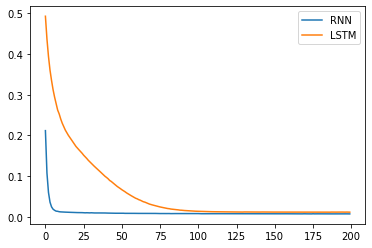

In [4]:
loss_rnn = history_rnn.history['loss']
loss_lstm = history_lstm.history['loss']

plt.plot(np.arange(len(loss_rnn)), loss_rnn, label="RNN")
plt.plot(np.arange(len(loss_lstm)), loss_lstm, label="LSTM")
plt.legend()
plt.show()

モデルが複雑なため、LSTMの方が誤差の収束にエポック数が必要です。

## 学習済みモデルの使用
それぞれの学習済みモデルを使って、サイン関数の次の値を予測します。

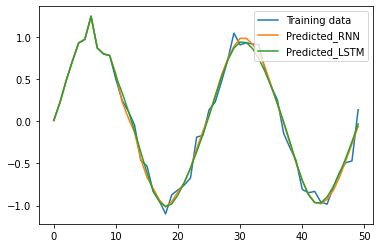

In [5]:
predicted_rnn = x[0].reshape(-1) 
predicted_lstm = x[0].reshape(-1) 

for i in range(0, n_sample):
    y_rnn = model_rnn.predict(predicted_rnn[-n_rnn:].reshape(1, n_rnn, 1))
    predicted_rnn = np.append(predicted_rnn, y_rnn[0][0])
    y_lstm = model_lstm.predict(predicted_lstm[-n_rnn:].reshape(1, n_rnn, 1))
    predicted_lstm = np.append(predicted_lstm, y_lstm[0][0])

plt.plot(np.arange(len(sin_data)), sin_data, label="Training data")
plt.plot(np.arange(len(predicted_rnn)), predicted_rnn, label="Predicted_RNN")
plt.plot(np.arange(len(predicted_lstm)), predicted_lstm, label="Predicted_LSTM")
plt.legend()
plt.show()

LSTMを使ったモデルが、サインカーブを学習できていることが分かります。  

このように、LSTMはRNNと同様に時系列データの学習ができるのですが、パラメータ数が多くモデルが複雑なため学習に時間がかかります。  
今回の例からはLSTMのメリットはあまり分かりませんが、文脈が大事な自然言語処理などで、LSTMはその真価を発揮します。

## 課題
サイン関数以外の、様々な関数をLSTMに学習させてみましょう。